# q-space에서만 diffusion 하는 smapling 방식 실험.

In [35]:
## import libararies
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys
import copy

from torch_scatter import scatter_add

from lst_interp import *
import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns

import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS

In [2]:
## Experiment setting : random seed, precision, device
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)
torch.set_default_dtype(torch.float64)
torch.set_num_threads(4)

In [3]:
class SamplingParams:
    def __init__(
        self,
        sampling_type,
        c=0.1,
        beta_std=0.125,
        sigma_max=1e-1,
        sigma_min=1e-7,
        sigma1_correction=1e-7,
    ):
        assert sampling_type in ["bell-shaped", "linear", "constant"]
        self.sampling_type = sampling_type
        print(f"Debug: sampling_type = {sampling_type}")

        if sampling_type in ["linear", "constant"]:
            # recommend c=0.1 for "linear", c=np.sqrt(0.1) for "constant"
            self.c = c
            self.sigma_min = sigma_min
            self.sigma_1 = self.sigma_square(1.0)
            self.sigma_0 = self.sigma_square(0.0)
            print(f"Debug: self.c = {self.c}")
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        elif sampling_type == "bell-shaped":
            self.sigma_linear_coef = 0.0
            self.beta_std = beta_std
            self.sigma_max = sigma_max
            if sigma_min is None:
                self.sigma_min = sigma_max * 5e-3
            else:
                self.sigma_min = sigma_min
            self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))

            self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
            self.sigma_0 = self.sigma_square(0.0)
            # print(self.sigma_1, self.sigma_0)
            print("Debug: std_beta, sigma_max, sigma_min = ", std_beta, sigma_max, sigma_min)
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        else:
            raise NotImplementedError
        return

    def beta(self, t):
        if self.sampling_type == "linear":
            b = self.c * 2 * t
        elif self.sampling_type == "constant":
            b = self.c**2 * torch.ones_like(t)
        elif self.sampling_type == "bell-shaped":
            if isinstance(t, torch.Tensor):
                b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            else:
                b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            b = b * self.normalizer * self.sigma_max
            b += self.sigma_linear_coef
        else:
            raise NotImplementedError
        return b

    def sigma_square(self, t):
        if self.sampling_type == "linear":
            # s_sq = self.c * t**2 + 1e-4
            s_sq = self.c * t**2 + self.sigma_min
        elif self.sampling_type == "constant":
            # s_sq = self.c**2 * t + 1e-3
            s_sq = self.c**2 * t + self.sigma_min
        elif self.sampling_type == "bell-shaped":
            erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
            if isinstance(t, torch.Tensor):
                s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
            else:
                s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
        else:
            raise NotImplementedError
        return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1

Debug: sampling_type = bell-shaped
Debug: std_beta, sigma_max, sigma_min =  0.125 0.01 1e-06
Debug: sigma_1, sigma_0 =  0.010001376575163336 2e-06


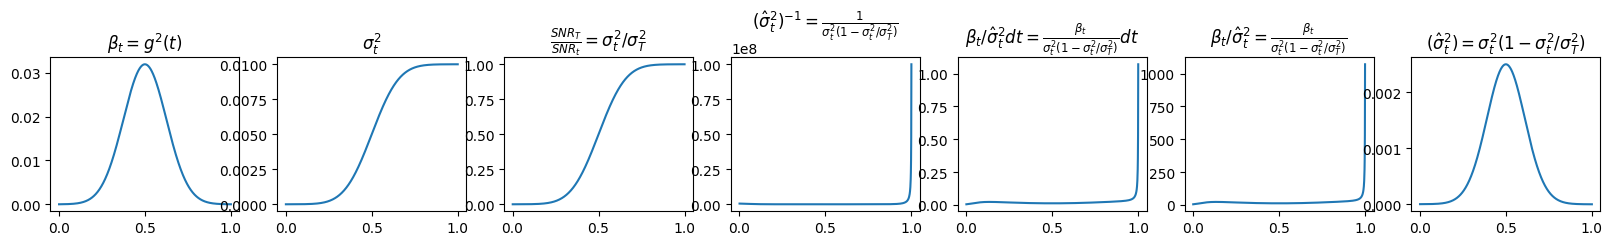

In [4]:
## Set sampling parameters

sampling_type = ["bell-shaped", "linear", "constant"][0]

if sampling_type in ["linear", "constant"]:
    # for linear and square sampling
    c = 0.1
    sigma_min = 1e-7
    sigma_max = 0.1
    std_beta = None
    sigma1_correction = None
else:
    # bell-shaped sampling
    c = 0.1
    # std_beta = 0.125
    std_beta = 0.125
    # sigma_max = 0.10
    sigma_max = 0.01
    sigma_min = 1e-6
    sigma1_correction = 1e-8


params = SamplingParams(
    sampling_type=sampling_type,
    c=c,
    beta_std=std_beta,
    sigma_max=sigma_max,
    sigma_min=sigma_min,
    sigma1_correction=sigma1_correction,
    )

## t samples
num_time_steps = 1000
# t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
t = torch.linspace(0, 1, num_time_steps + 1)[1:]
# t = torch.cat(
#     (torch.linspace(0, 0.5, int(num_time_steps * 0.5)), torch.linspace(0.5, 1, int(num_time_steps * 0.5))),
#     dim=0,
# )
# dt = 
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)


## plot
fig, axs = plt.subplots(1, 7, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12
axs = axs.flatten()

ax = axs[0];ax.plot(t, betas);ax.set_title(r"$\beta_t = g^2(t)$")
ax = axs[1];ax.plot(t, sigma_square);ax.set_title("$\sigma_{t}^{2}$")
ax = axs[2];ax.plot(t, SNRTt);ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")
ax = axs[3];ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 / sigma_square / (1 - SNRTt)))
ax = axs[4];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * 1 / len(betas))
ax = axs[5];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)))
ax = axs[6];ax.set_title(r"$(\hat{\sigma}_t^2)={\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 * sigma_square * (1 - SNRTt)))

In [5]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))

In [106]:
## wrapper class to save atoms object

class Wrapper:
    def __init__(self, atoms_0, atoms_T, q_type="DM", alpha=1.7, beta=0.01, gamma=0.01, using_jacobian=True):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type

        self.re = torch.Tensor(self.get_re(atoms_T))
        # self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0
        self.using_jacobian = using_jacobian
        return


    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def calc_jacobian(self, pos, q_type):
        # pos = Tensor, (N, 3)
        edge_index, edge_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        jacobian = []
        for i_idx in range(len(pos)):
            j_idx = list(range(len(pos)))
            j_idx.remove(i_idx)
            j_idx = torch.LongTensor(j_idx)

            j_mask = torch.any(edge_index == i_idx, axis=0)
            dd_dx = torch.zeros(size=(len(edge_length), 3))
            dq_dx = torch.zeros(size=(len(edge_length), 3))
            pos_i = pos[i_idx].reshape(1, -1)
            pos_j = pos[j_idx]

            dist = distance[j_mask].reshape(-1, 1)
            dd_dx[j_mask] += (pos_i - pos_j) / dist

            if q_type == "DM":
                jacobian.append(dd_dx.T)

            elif q_type == "morse":
                dq_dd = - (self.alpha / distance_e[j_mask]) * np.exp(-self.alpha * (distance[j_mask] - distance_e[j_mask]) / distance_e[j_mask])
                dq_dd -= self.beta * distance_e[j_mask] / (distance[j_mask] ** 2)
                dq_dx[j_mask] += dd_dx[j_mask] * dq_dd.reshape(-1, 1)
                jacobian.append(dq_dx.T)
                
            elif q_type == "morese+DM":
                raise NotImplementedError

        return torch.cat(jacobian, dim=0)
    
    def calc_distance_hessian(self, pos, edge_index, distance):
        N = len(pos)
        K = len(edge_index)
        hessian = torch.zeros(size=(K, 3 * N, 3 * N))
        for k, (ij, d_ij) in enumerate(zip(edge_index, distance)):
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]

            # calculate hessian related to i, j atoms
            d_pos = pos_i - pos_j
            hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ij /= d_ij ** 3
            hess_ij -= torch.eye(3) / d_ij
            
            # calculate hessian related to i, i atoms
            hess_ii = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ii /= - d_ij ** 3
            hess_ii += torch.eye(3) / d_ij
            
            # hess_ii = hess_jj
            hess_jj = hess_ii

            hessian[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
            hessian[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_jj
            hessian[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
            hessian[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
            
        return hessian
    
    def calc_hessian(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
            
        edge_index, edge_length = self.pos_to_dist(pos)
        edge_index = edge_index.T
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        hessian = self.calc_distance_hessian(pos, edge_index, distance)
        
        if q_type == "DM":
            return hessian
        
        elif q_type == "morse":
            dq_dd = - self.alpha / distance_e * np.exp(-self.alpha * (distance - distance_e) / distance_e)
            dq_dd -= self.beta * distance_e / (distance ** 2)
            hessian_q = hessian * dq_dd.reshape(-1, 1, 1)
            
            for k, (ij, d_ij, de_ij) in enumerate(zip(edge_index, distance, distance_e)):
                i, j = ij
                pos_i, pos_j = pos[i], pos[j]
                # calculate hessian related to i, j atoms
                d_pos = pos_i - pos_j
                hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
                hess_ij /= - d_ij ** 2
                coeff = self.alpha ** 2 / de_ij ** 2 * np.exp(-self.alpha * (d_ij - de_ij) / de_ij)  + 2 * self.beta * de_ij / (d_ij ** 3)
                hess_ij *= coeff

                # calculate hessian related to i, i atoms
                hess_ii = - hess_ij
                
                hessian_q[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
                hessian_q[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_ii
                hessian_q[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
                hessian_q[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
                
            return hessian_q
        
        elif q_type == "morese+DM":
            raise NotImplementedError
        return 
             
    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.using_jacobian:
            jacobian = self.calc_jacobian(pos, q_type=self.q_type)
            
            score_pos = jacobian @ score_d.reshape(-1, 1)
            return score_pos.reshape(-1, 3)
            
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
        if q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            # print(wij, type(wij))
            # length = torch.Tensor(wij)
            length = wij
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                                  using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
            dx = - 1.0 * reverse_score_ * dt + dw
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index, d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                # every displacement is first calculated on the q-space, and then transformed to the Cartesian space
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw

                dx = self.eq_transform(dd, x_t, index, d_t)
            
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw   
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=5)
                dx = - x_tm1 + x_t
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                            using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dx = - 0.5 * reverse_score_ * dt
            print(f"Debug ({t:0.3f}): \n\t1) diff norm and dx norm {diff.norm():0.4f}, {dx.norm():0.6f}")
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index ,d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                dx = self.eq_transform(dd, x_t, index, d_t)                
                # Want to check why eq-transform does not work well
                diff_d = diff
                diff_x = self.eq_transform(diff_d, x_t, index, d_t)
                print(f"Debug ({t:0.3f}): \n\t1) diff-d norm and diff-x norm {diff_d.norm():0.4f}, {diff_x.norm():0.4f} \n\t2) dd-norm and dx-norm {dd.norm():0.6f}, {dx.norm():0.6f}")
                print(f"\t3) dx-norm/dd-norm {dx.norm()/dd.norm():0.6f}")
                
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                print(f"debug ] time : {t:0.3f}")
                print(f"debug ] diff.norm() : {diff.norm()}")
                print(f"debug ] dd.norm() : {dd.norm()}")
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                print(f"debug ] dx.norm() : {dx.norm()}")
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff * coeff
        
        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM", "Cartesian"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return diff, coeff, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff = diff_d
        coeff =  1 / (sigma_t_hat_square) * beta_t

        # for debugging
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v_loss_mae = (d_mu_hat - d_t).abs().mean()  # DMAE
        v_acc_mae = (d_0 - d_t).abs().mean()  # DMAE

        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v_loss_norm = (d_mu_hat - d_t).norm()  # q-norm
        v_acc_norm = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v_loss_mae:0.4f}\t\t{v_acc_mae:0.4f}\t\t{v_loss_norm:0.4f}\t\t{v_acc_norm:0.4f}\t")
        return diff, coeff, v_loss_mae, v_acc_mae, v_loss_norm, v_acc_norm
    
    def exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10):
        
        t = torch.linspace(0, 1, num_iter + 1)[:-1]
        dt = t[1] - t[0]
        
        def one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=False):
            hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
            jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
            
            J, J_inv = wrapper.refine_jacobian(jacob)
            JG = J_inv.T
            
            if refine_xdot:
                x_dot = J_inv @ J @ x_dot
            
            christoffel = torch.einsum("mij, mk->kij", hess, JG)
            x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
            # x_ddot and x_dot should be perpendicular 
            q_ddot = J @ x_ddot
            q_dot = J @ x_dot
            # remove q_dot component from q_ddot
            q_ddot -= (q_ddot * q_dot).sum() * q_dot / (q_dot * q_dot).sum()
            x_ddot = J_inv @ q_ddot
            
            new_x = x + x_dot * dt
            new_x_dot = x_dot + x_ddot * dt
            
            # dotproduct
            print(f"\t\tdebug: <x_ddot, x_dot> = {(q_ddot * q_dot).sum()}")
            print(f"\t\tdebug: dx norm = {(new_x - x).norm():0.4f}, dx_dot norm = {(new_x_dot - x_dot).norm():0.4f}")
            return new_x, new_x_dot
        
        jacob = self.calc_jacobian(x0, q_type=q_type)
        J, J_inv = self.refine_jacobian(jacob)
        
        # debugging
        proj_q_dot = J.T @ J_inv.T @ q_dot0
        print(f"\tdebug: proj_q_dot norm = {(proj_q_dot - q_dot0).norm()/ q_dot0.norm():0.4f}")
        
        x_dot0 = J_inv.T @ q_dot0
        x = x0.flatten()
        x_dot = x_dot0
        for i, t_i in enumerate(t):
            do_refine = i % check_dot_every == 0
            x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine)
        return x.reshape(-1, 3)
    
    
    def svd(self, jacob):
        U, S, Vh = torch.linalg.svd(jacob)
        # num_zeros = (S < 1e-14).sum()
        dim = len(S) - num_zeros
        S = S[:dim]
        U = U[:, :dim]
        Vh = Vh[:dim, :]
        return U, S, Vh

    def refine_jacobian(self, jacob):
        # find non-zero singular values
        U, S, Vh = self.svd(jacob)    
        J = U @ torch.diag(S) @ Vh
        J_inv = Vh.T @ torch.diag(1 / S) @ U.T
        return J, J_inv
        

In [151]:
idx = 10
q_type = "morse"
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

gamma = 0.0
alpha, beta = 1.7, 0.01

print(f"Debug: alpha, beta = {alpha}, {beta}")
wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True)

x0 = torch.Tensor(x0.positions)
xT = torch.Tensor(xT.positions)

jacob = wrapper.calc_jacobian(xT, q_type=q_type).T
U, S, Vh = torch.linalg.svd(jacob)
torch.set_printoptions(precision=14, sci_mode=False)
print(S[:-6])
print(S[-6:])
print(S[0] / S[-7])

Debug: alpha, beta = 1.7, 0.01
tensor([    2.73873219339027,     2.50125991879754,     2.33298072802214,
            2.13177624871448,     1.99512615181287,     1.74812919527982,
            1.62757177051697,     1.32296507900031,     1.06441141976421,
            0.95939710632883,     0.63740872566921,     0.62660073211519,
            0.54795895694028,     0.26242145469677,     0.21074888695142,
            0.00002279192760,     0.00000635883406,     0.00000410970659,
            0.00000247116628,     0.00000115446085,     0.00000047008556])
tensor([    0.00000000000000,     0.00000000000000,     0.00000000000000,
            0.00000000000000,     0.00000000000000,     0.00000000000000])
tensor(5826029.13078664429486)


In [70]:
q0 = wrapper.pos_to_dist(x0)[1]
qT = wrapper.pos_to_dist(xT)[1]
q_dot0 = (qT - q0)
print(torch.linalg.norm(q_dot0))
print(q_dot0.shape)
x = wrapper.exponential_ode_solver(x0, q_dot0, q_type=q_type, num_iter=100, check_dot_every=10)


tensor(0.236705)
torch.Size([78])


In [71]:
def rmsd(x):
    return (x ** 2).sum(-1).mean().sqrt()
print("\nRMSD")
print(rmsd((xT - x).reshape(-1, 3)))
print(rmsd((x0 - x).reshape(-1, 3)))
print(rmsd((xT - x0).reshape(-1, 3)))

q = wrapper.pos_to_dist(x)[1]
print("\nq")
print(torch.linalg.norm(qT - q))
print(torch.linalg.norm(q0 - q))
print(torch.linalg.norm(qT - q0))

d0 = torch.Tensor(pdist(x0))
d = torch.Tensor(pdist(x))
dT = torch.Tensor(pdist(xT))
print("\nd")
print(torch.abs(dT - d).mean())
print(torch.abs(d0 - d).mean())
print(torch.abs(dT - d0).mean())


RMSD
tensor(0.002238)
tensor(0.143995)
tensor(0.144917)

q
tensor(0.001090)
tensor(0.236190)
tensor(0.236705)

d
tensor(0.000702)
tensor(0.086254)
tensor(0.086598)


In [115]:
def experiment1(
    idx,
    sampling_type,
    coord_type,
    h_coeff=0.0,
    num_time_steps=200,
    verbose=False,
    plot=True,
    q_type="morse",
    sampling_test=1,
    atoms_0=atoms_0,
    atoms_T=atoms_T,
    inner_iteration=3,
    outer_iteration=None,
):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]
    
    print(f"idx, gt_idx: {idx}, {gt_idx}")
    gamma = 0.0
    alpha, beta = 1.7, 0.01
    
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True)

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())

    margin = 0.001
    # t = torch.linspace(0 + margin, 1 - 10 * margin, num_time_steps + 1)[:-1]
    t = torch.linspace(0 + margin, 0.9, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
    # for idx, i in tqdm.tqdm(enumerate(torch.flip(t, dims=(0,))), total=len(t)):
        if sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)
        else: # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
        
        if idx == outer_iteration: break

    return reverse_traj, v1s, v2s, v3s, v4s


def plot_traj(v, label="", ylabel=""): # r"||$\hat{d}_t - d_t$||"
    plt.plot(v, label=label)
    plt.xlabel(r"time step", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    return

q_type = morse
idx, gt_idx: 34, 49
Debug: alpha, beta = 1.7, 0.01
debug ] time : 0.896
debug ] diff.norm() : 0.0001646069424793432
debug ] dd.norm() : 8.50075997178042e-06
	debug: proj_q_dot norm = 0.0987
		debug: <x_ddot, x_dot> = -6.310887241768094e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = 3.7865323450608567e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = 7.573064690121713e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = 3.7865323450608567e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = 3.7865323450608567e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = -3.7865323450608567e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = 1.135959703518257e-28
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x_ddot, x_dot> = -3.7865323450608567e-29
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
		debug: <x

IndexError: list index out of range

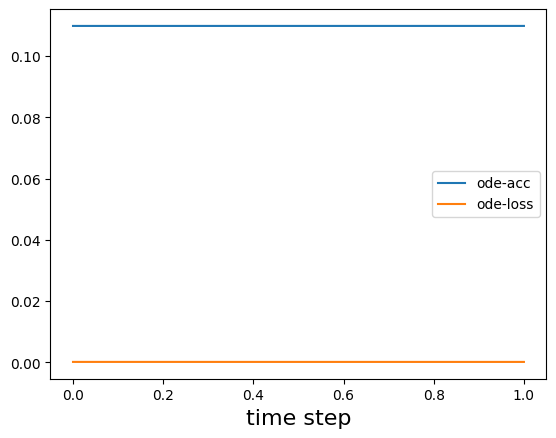

In [117]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

num_time_steps = [100, 250, 500, 1000][1]
# num_time_steps = 40
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
print(f"q_type = {q_type}")

for idx in [34]:
# for idx in [2]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test, 
                                               inner_iteration=10, outer_iteration=1)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")
    
    plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

q_type = morse
Debug: alpha, beta = 1.7, 0.01


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


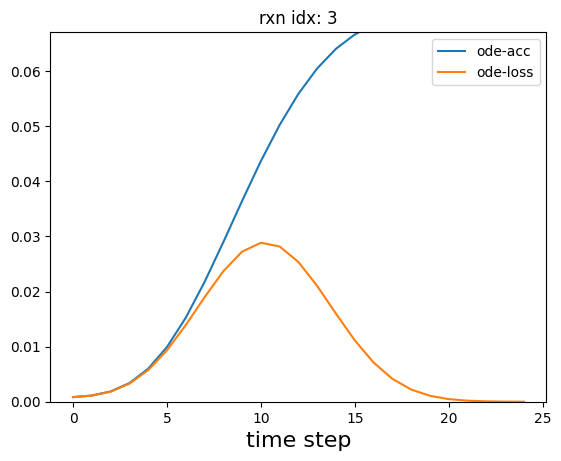

err_at_zero_t =  [0.0008384198468590583]
Done!


In [45]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

num_time_steps = [100, 250, 500, 1000][0]
num_time_steps = 25
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
print(f"q_type = {q_type}")

for idx in [3, ]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")
    
    plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

In [67]:
v1[:3], v2[:3]

([tensor(0.000145), tensor(0.000220), tensor(209955025.572686)],
 [tensor(0.109847), tensor(0.109803), tensor(209955025.641975)])

# =============================================================

q_type = morse
Debug: alpha, beta = 1.7, 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Debug (0.989): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000001
	3) dx-norm/dd-norm 1.001111
Debug (0.979): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000001
	3) dx-norm/dd-norm 0.578674
Debug (0.969): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000002, 0.000001
	3) dx-norm/dd-norm 0.715113


  8%|▊         | 8/100 [00:00<00:02, 34.18it/s]

Debug (0.959): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000002, 0.000001
	3) dx-norm/dd-norm 0.586094
Debug (0.949): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000003, 0.000002
	3) dx-norm/dd-norm 0.606315
Debug (0.939): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000004, 0.000002
	3) dx-norm/dd-norm 0.602662
Debug (0.929): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000005, 0.000003
	3) dx-norm/dd-norm 0.602759
Debug (0.919): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000007, 0.000004
	3) dx-norm/dd-norm 0.602434
Debug (0.909): 
	1) diff-d norm and diff-x norm 0.0001, 0.0000 
	2) dd-norm and dx-norm 0.000009, 0.000005
	3) dx-norm/dd-norm 0.602095
Debug (0.899): 
	1) diff-d norm and diff-x norm 0.0001, 0.0000 
	2) dd-norm and dx-norm 0.000011, 0.000007
	3) dx-norm/dd-norm 0.601727
Debug (0.889): 
	1) diff-d norm and diff-x norm 

 16%|█▌        | 16/100 [00:00<00:02, 35.30it/s]

Debug (0.879): 
	1) diff-d norm and diff-x norm 0.0001, 0.0001 
	2) dd-norm and dx-norm 0.000019, 0.000011
	3) dx-norm/dd-norm 0.600933
Debug (0.869): 
	1) diff-d norm and diff-x norm 0.0002, 0.0001 
	2) dd-norm and dx-norm 0.000024, 0.000014
	3) dx-norm/dd-norm 0.600513
Debug (0.859): 
	1) diff-d norm and diff-x norm 0.0002, 0.0001 
	2) dd-norm and dx-norm 0.000030, 0.000018
	3) dx-norm/dd-norm 0.600078
Debug (0.849): 
	1) diff-d norm and diff-x norm 0.0003, 0.0002 
	2) dd-norm and dx-norm 0.000038, 0.000023
	3) dx-norm/dd-norm 0.599629
Debug (0.839): 
	1) diff-d norm and diff-x norm 0.0004, 0.0002 
	2) dd-norm and dx-norm 0.000047, 0.000028
	3) dx-norm/dd-norm 0.599164
Debug (0.829): 
	1) diff-d norm and diff-x norm 0.0005, 0.0003 
	2) dd-norm and dx-norm 0.000059, 0.000035
	3) dx-norm/dd-norm 0.598681
Debug (0.819): 
	1) diff-d norm and diff-x norm 0.0006, 0.0004 
	2) dd-norm and dx-norm 0.000072, 0.000043
	3) dx-norm/dd-norm 0.598179
Debug (0.809): 
	1) diff-d norm and diff-x norm 

 20%|██        | 20/100 [00:00<00:02, 35.74it/s]

Debug (0.799): 
	1) diff-d norm and diff-x norm 0.0010, 0.0006 
	2) dd-norm and dx-norm 0.000107, 0.000064
	3) dx-norm/dd-norm 0.597098
Debug (0.789): 
	1) diff-d norm and diff-x norm 0.0012, 0.0007 
	2) dd-norm and dx-norm 0.000130, 0.000077
	3) dx-norm/dd-norm 0.596511
Debug (0.779): 
	1) diff-d norm and diff-x norm 0.0015, 0.0009 
	2) dd-norm and dx-norm 0.000156, 0.000093
	3) dx-norm/dd-norm 0.595886
Debug (0.769): 
	1) diff-d norm and diff-x norm 0.0018, 0.0011 
	2) dd-norm and dx-norm 0.000186, 0.000111
	3) dx-norm/dd-norm 0.595216
Debug (0.759): 
	1) diff-d norm and diff-x norm 0.0022, 0.0013 
	2) dd-norm and dx-norm 0.000221, 0.000131
	3) dx-norm/dd-norm 0.594495


 25%|██▌       | 25/100 [00:00<00:02, 37.37it/s]

Debug (0.750): 
	1) diff-d norm and diff-x norm 0.0027, 0.0016 
	2) dd-norm and dx-norm 0.000261, 0.000155
	3) dx-norm/dd-norm 0.593716
Debug (0.740): 
	1) diff-d norm and diff-x norm 0.0032, 0.0019 
	2) dd-norm and dx-norm 0.000307, 0.000182
	3) dx-norm/dd-norm 0.592869
Debug (0.730): 
	1) diff-d norm and diff-x norm 0.0039, 0.0023 
	2) dd-norm and dx-norm 0.000358, 0.000212
	3) dx-norm/dd-norm 0.591945


 29%|██▉       | 29/100 [00:00<00:01, 37.71it/s]

Debug (0.720): 
	1) diff-d norm and diff-x norm 0.0046, 0.0027 
	2) dd-norm and dx-norm 0.000416, 0.000246
	3) dx-norm/dd-norm 0.590936
Debug (0.710): 
	1) diff-d norm and diff-x norm 0.0055, 0.0032 
	2) dd-norm and dx-norm 0.000480, 0.000283
	3) dx-norm/dd-norm 0.589831
Debug (0.700): 
	1) diff-d norm and diff-x norm 0.0065, 0.0038 
	2) dd-norm and dx-norm 0.000551, 0.000324
	3) dx-norm/dd-norm 0.588619
Debug (0.690): 
	1) diff-d norm and diff-x norm 0.0076, 0.0044 
	2) dd-norm and dx-norm 0.000630, 0.000370
	3) dx-norm/dd-norm 0.587289
Debug (0.680): 
	1) diff-d norm and diff-x norm 0.0088, 0.0052 
	2) dd-norm and dx-norm 0.000716, 0.000420
	3) dx-norm/dd-norm 0.585830


 33%|███▎      | 33/100 [00:00<00:01, 37.68it/s]

Debug (0.670): 
	1) diff-d norm and diff-x norm 0.0102, 0.0060 
	2) dd-norm and dx-norm 0.000810, 0.000473
	3) dx-norm/dd-norm 0.584230
Debug (0.660): 
	1) diff-d norm and diff-x norm 0.0117, 0.0068 
	2) dd-norm and dx-norm 0.000913, 0.000532
	3) dx-norm/dd-norm 0.582478
Debug (0.650): 
	1) diff-d norm and diff-x norm 0.0134, 0.0078 
	2) dd-norm and dx-norm 0.001023, 0.000594
	3) dx-norm/dd-norm 0.580562


 37%|███▋      | 37/100 [00:01<00:01, 37.73it/s]

Debug (0.640): 
	1) diff-d norm and diff-x norm 0.0153, 0.0089 
	2) dd-norm and dx-norm 0.001141, 0.000660
	3) dx-norm/dd-norm 0.578471
Debug (0.630): 
	1) diff-d norm and diff-x norm 0.0174, 0.0100 
	2) dd-norm and dx-norm 0.001268, 0.000731
	3) dx-norm/dd-norm 0.576196
Debug (0.620): 
	1) diff-d norm and diff-x norm 0.0196, 0.0112 
	2) dd-norm and dx-norm 0.001403, 0.000805
	3) dx-norm/dd-norm 0.573725
Debug (0.610): 
	1) diff-d norm and diff-x norm 0.0219, 0.0125 
	2) dd-norm and dx-norm 0.001545, 0.000882
	3) dx-norm/dd-norm 0.571049
Debug (0.600): 
	1) diff-d norm and diff-x norm 0.0245, 0.0139 
	2) dd-norm and dx-norm 0.001696, 0.000963
	3) dx-norm/dd-norm 0.568162


 41%|████      | 41/100 [00:01<00:01, 38.06it/s]

Debug (0.590): 
	1) diff-d norm and diff-x norm 0.0272, 0.0154 
	2) dd-norm and dx-norm 0.001854, 0.001047
	3) dx-norm/dd-norm 0.565056
Debug (0.580): 
	1) diff-d norm and diff-x norm 0.0300, 0.0169 
	2) dd-norm and dx-norm 0.002019, 0.001134
	3) dx-norm/dd-norm 0.561726
Debug (0.570): 
	1) diff-d norm and diff-x norm 0.0330, 0.0184 
	2) dd-norm and dx-norm 0.002191, 0.001223
	3) dx-norm/dd-norm 0.558169


 46%|████▌     | 46/100 [00:01<00:01, 38.79it/s]

Debug (0.560): 
	1) diff-d norm and diff-x norm 0.0361, 0.0200 
	2) dd-norm and dx-norm 0.002370, 0.001314
	3) dx-norm/dd-norm 0.554382
Debug (0.550): 
	1) diff-d norm and diff-x norm 0.0393, 0.0216 
	2) dd-norm and dx-norm 0.002555, 0.001406
	3) dx-norm/dd-norm 0.550368
Debug (0.540): 
	1) diff-d norm and diff-x norm 0.0425, 0.0232 
	2) dd-norm and dx-norm 0.002746, 0.001500
	3) dx-norm/dd-norm 0.546128
Debug (0.530): 
	1) diff-d norm and diff-x norm 0.0458, 0.0248 
	2) dd-norm and dx-norm 0.002942, 0.001594
	3) dx-norm/dd-norm 0.541669
Debug (0.520): 
	1) diff-d norm and diff-x norm 0.0492, 0.0264 
	2) dd-norm and dx-norm 0.003143, 0.001688
	3) dx-norm/dd-norm 0.536996


 50%|█████     | 50/100 [00:01<00:01, 38.64it/s]

Debug (0.510): 
	1) diff-d norm and diff-x norm 0.0525, 0.0279 
	2) dd-norm and dx-norm 0.003348, 0.001782
	3) dx-norm/dd-norm 0.532122
Debug (0.500): 
	1) diff-d norm and diff-x norm 0.0558, 0.0294 
	2) dd-norm and dx-norm 0.003557, 0.001875
	3) dx-norm/dd-norm 0.527058
Debug (0.490): 
	1) diff-d norm and diff-x norm 0.0591, 0.0309 
	2) dd-norm and dx-norm 0.003769, 0.001967
	3) dx-norm/dd-norm 0.521821


 54%|█████▍    | 54/100 [00:01<00:01, 38.53it/s]

Debug (0.480): 
	1) diff-d norm and diff-x norm 0.0623, 0.0322 
	2) dd-norm and dx-norm 0.003984, 0.002057
	3) dx-norm/dd-norm 0.516427
Debug (0.470): 
	1) diff-d norm and diff-x norm 0.0654, 0.0334 
	2) dd-norm and dx-norm 0.004201, 0.002146
	3) dx-norm/dd-norm 0.510897
Debug (0.460): 
	1) diff-d norm and diff-x norm 0.0684, 0.0346 
	2) dd-norm and dx-norm 0.004419, 0.002233
	3) dx-norm/dd-norm 0.505253
Debug (0.450): 
	1) diff-d norm and diff-x norm 0.0713, 0.0356 
	2) dd-norm and dx-norm 0.004638, 0.002317
	3) dx-norm/dd-norm 0.499518
Debug (0.440): 
	1) diff-d norm and diff-x norm 0.0740, 0.0365 
	2) dd-norm and dx-norm 0.004858, 0.002398
	3) dx-norm/dd-norm 0.493717


 58%|█████▊    | 58/100 [00:01<00:01, 38.68it/s]

Debug (0.430): 
	1) diff-d norm and diff-x norm 0.0765, 0.0373 
	2) dd-norm and dx-norm 0.005077, 0.002477
	3) dx-norm/dd-norm 0.487875
Debug (0.420): 
	1) diff-d norm and diff-x norm 0.0788, 0.0380 
	2) dd-norm and dx-norm 0.005295, 0.002553
	3) dx-norm/dd-norm 0.482016
Debug (0.410): 
	1) diff-d norm and diff-x norm 0.0809, 0.0385 
	2) dd-norm and dx-norm 0.005513, 0.002625
	3) dx-norm/dd-norm 0.476166


 62%|██████▏   | 62/100 [00:01<00:01, 37.80it/s]

Debug (0.400): 
	1) diff-d norm and diff-x norm 0.0828, 0.0389 
	2) dd-norm and dx-norm 0.005728, 0.002694
	3) dx-norm/dd-norm 0.470348
Debug (0.390): 
	1) diff-d norm and diff-x norm 0.0845, 0.0392 
	2) dd-norm and dx-norm 0.005941, 0.002760
	3) dx-norm/dd-norm 0.464582
Debug (0.380): 
	1) diff-d norm and diff-x norm 0.0859, 0.0394 
	2) dd-norm and dx-norm 0.006151, 0.002822
	3) dx-norm/dd-norm 0.458888
Debug (0.370): 
	1) diff-d norm and diff-x norm 0.0871, 0.0395 
	2) dd-norm and dx-norm 0.006357, 0.002882
	3) dx-norm/dd-norm 0.453280
Debug (0.360): 
	1) diff-d norm and diff-x norm 0.0881, 0.0395 
	2) dd-norm and dx-norm 0.006560, 0.002937
	3) dx-norm/dd-norm 0.447773


 66%|██████▌   | 66/100 [00:01<00:00, 37.65it/s]

Debug (0.350): 
	1) diff-d norm and diff-x norm 0.0889, 0.0393 
	2) dd-norm and dx-norm 0.006758, 0.002990
	3) dx-norm/dd-norm 0.442375
Debug (0.340): 
	1) diff-d norm and diff-x norm 0.0895, 0.0391 
	2) dd-norm and dx-norm 0.006952, 0.003039
	3) dx-norm/dd-norm 0.437091
Debug (0.330): 
	1) diff-d norm and diff-x norm 0.0899, 0.0388 
	2) dd-norm and dx-norm 0.007140, 0.003084
	3) dx-norm/dd-norm 0.431923


 70%|███████   | 70/100 [00:01<00:00, 37.53it/s]

Debug (0.320): 
	1) diff-d norm and diff-x norm 0.0901, 0.0385 
	2) dd-norm and dx-norm 0.007323, 0.003126
	3) dx-norm/dd-norm 0.426871
Debug (0.310): 
	1) diff-d norm and diff-x norm 0.0902, 0.0381 
	2) dd-norm and dx-norm 0.007499, 0.003164
	3) dx-norm/dd-norm 0.421930
Debug (0.300): 
	1) diff-d norm and diff-x norm 0.0901, 0.0376 
	2) dd-norm and dx-norm 0.007670, 0.003199
	3) dx-norm/dd-norm 0.417094
Debug (0.290): 
	1) diff-d norm and diff-x norm 0.0898, 0.0370 
	2) dd-norm and dx-norm 0.007833, 0.003230
	3) dx-norm/dd-norm 0.412355
Debug (0.280): 
	1) diff-d norm and diff-x norm 0.0894, 0.0364 
	2) dd-norm and dx-norm 0.007990, 0.003258
	3) dx-norm/dd-norm 0.407704


 74%|███████▍  | 74/100 [00:01<00:00, 37.42it/s]

Debug (0.270): 
	1) diff-d norm and diff-x norm 0.0889, 0.0358 
	2) dd-norm and dx-norm 0.008139, 0.003281
	3) dx-norm/dd-norm 0.403129
Debug (0.260): 
	1) diff-d norm and diff-x norm 0.0882, 0.0352 
	2) dd-norm and dx-norm 0.008280, 0.003301
	3) dx-norm/dd-norm 0.398622
Debug (0.251): 
	1) diff-d norm and diff-x norm 0.0875, 0.0345 
	2) dd-norm and dx-norm 0.008413, 0.003316
	3) dx-norm/dd-norm 0.394173


 78%|███████▊  | 78/100 [00:02<00:00, 37.53it/s]

Debug (0.241): 
	1) diff-d norm and diff-x norm 0.0867, 0.0338 
	2) dd-norm and dx-norm 0.008537, 0.003328
	3) dx-norm/dd-norm 0.389772
Debug (0.231): 
	1) diff-d norm and diff-x norm 0.0858, 0.0331 
	2) dd-norm and dx-norm 0.008652, 0.003334
	3) dx-norm/dd-norm 0.385412
Debug (0.221): 
	1) diff-d norm and diff-x norm 0.0849, 0.0324 
	2) dd-norm and dx-norm 0.008756, 0.003337
	3) dx-norm/dd-norm 0.381086
Debug (0.211): 
	1) diff-d norm and diff-x norm 0.0840, 0.0316 
	2) dd-norm and dx-norm 0.008848, 0.003334
	3) dx-norm/dd-norm 0.376791
Debug (0.201): 
	1) diff-d norm and diff-x norm 0.0829, 0.0309 
	2) dd-norm and dx-norm 0.008928, 0.003326
	3) dx-norm/dd-norm 0.372523


 82%|████████▏ | 82/100 [00:02<00:00, 37.53it/s]

Debug (0.191): 
	1) diff-d norm and diff-x norm 0.0819, 0.0302 
	2) dd-norm and dx-norm 0.008992, 0.003312
	3) dx-norm/dd-norm 0.368283
Debug (0.181): 
	1) diff-d norm and diff-x norm 0.0809, 0.0294 
	2) dd-norm and dx-norm 0.009038, 0.003291
	3) dx-norm/dd-norm 0.364072
Debug (0.171): 
	1) diff-d norm and diff-x norm 0.0798, 0.0287 
	2) dd-norm and dx-norm 0.009064, 0.003262
	3) dx-norm/dd-norm 0.359895


 86%|████████▌ | 86/100 [00:02<00:00, 37.69it/s]

Debug (0.161): 
	1) diff-d norm and diff-x norm 0.0787, 0.0280 
	2) dd-norm and dx-norm 0.009064, 0.003225
	3) dx-norm/dd-norm 0.355759
Debug (0.151): 
	1) diff-d norm and diff-x norm 0.0777, 0.0273 
	2) dd-norm and dx-norm 0.009034, 0.003177
	3) dx-norm/dd-norm 0.351674
Debug (0.141): 
	1) diff-d norm and diff-x norm 0.0767, 0.0266 
	2) dd-norm and dx-norm 0.008965, 0.003117
	3) dx-norm/dd-norm 0.347652
Debug (0.131): 
	1) diff-d norm and diff-x norm 0.0756, 0.0260 
	2) dd-norm and dx-norm 0.008850, 0.003042
	3) dx-norm/dd-norm 0.343709
Debug (0.121): 
	1) diff-d norm and diff-x norm 0.0746, 0.0254 
	2) dd-norm and dx-norm 0.008678, 0.002950
	3) dx-norm/dd-norm 0.339866


 90%|█████████ | 90/100 [00:02<00:00, 37.70it/s]

Debug (0.111): 
	1) diff-d norm and diff-x norm 0.0737, 0.0248 
	2) dd-norm and dx-norm 0.008439, 0.002837
	3) dx-norm/dd-norm 0.336145
Debug (0.101): 
	1) diff-d norm and diff-x norm 0.0727, 0.0242 
	2) dd-norm and dx-norm 0.008121, 0.002701
	3) dx-norm/dd-norm 0.332573
Debug (0.091): 
	1) diff-d norm and diff-x norm 0.0719, 0.0237 
	2) dd-norm and dx-norm 0.007715, 0.002539
	3) dx-norm/dd-norm 0.329180


 94%|█████████▍| 94/100 [00:02<00:00, 37.68it/s]

Debug (0.081): 
	1) diff-d norm and diff-x norm 0.0711, 0.0232 
	2) dd-norm and dx-norm 0.007214, 0.002352
	3) dx-norm/dd-norm 0.325998
Debug (0.071): 
	1) diff-d norm and diff-x norm 0.0703, 0.0227 
	2) dd-norm and dx-norm 0.006621, 0.002139
	3) dx-norm/dd-norm 0.323061
Debug (0.061): 
	1) diff-d norm and diff-x norm 0.0696, 0.0223 
	2) dd-norm and dx-norm 0.005947, 0.001905
	3) dx-norm/dd-norm 0.320399
Debug (0.051): 
	1) diff-d norm and diff-x norm 0.0690, 0.0220 
	2) dd-norm and dx-norm 0.005215, 0.001659
	3) dx-norm/dd-norm 0.318036
Debug (0.041): 
	1) diff-d norm and diff-x norm 0.0685, 0.0216 
	2) dd-norm and dx-norm 0.004457, 0.001408
	3) dx-norm/dd-norm 0.315986


 98%|█████████▊| 98/100 [00:02<00:00, 37.93it/s]

Debug (0.031): 
	1) diff-d norm and diff-x norm 0.0681, 0.0214 
	2) dd-norm and dx-norm 0.003710, 0.001166
	3) dx-norm/dd-norm 0.314251
Debug (0.021): 
	1) diff-d norm and diff-x norm 0.0677, 0.0212 
	2) dd-norm and dx-norm 0.003010, 0.000941
	3) dx-norm/dd-norm 0.312818
Debug (0.011): 
	1) diff-d norm and diff-x norm 0.0674, 0.0210 
	2) dd-norm and dx-norm 0.002382, 0.000742
	3) dx-norm/dd-norm 0.311665


100%|██████████| 100/100 [00:02<00:00, 37.45it/s]


Debug (0.001): 
	1) diff-d norm and diff-x norm 0.0672, 0.0209 
	2) dd-norm and dx-norm 0.001843, 0.000573
	3) dx-norm/dd-norm 0.310757


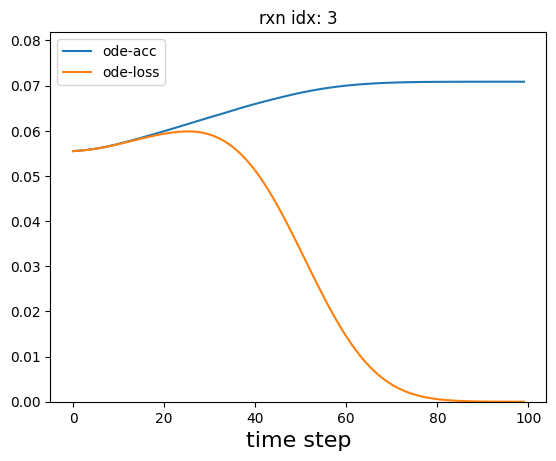

err_at_zero_t =  [0.055505851397022125]
Done!


In [40]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

num_time_steps = [100, 250, 500, 1000][1]
num_time_steps = 100
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][0]
print(f"q_type = {q_type}")

for idx in [3, ]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")
    
    plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

q_type = DM
Debug: alpha, beta = 1.7, 0.01
Debug (0.997): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000004
	3) dx-norm/dd-norm 2.634832
Debug (0.995): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000004
	3) dx-norm/dd-norm 3.362622
Debug (0.993): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000002, 0.000006
	3) dx-norm/dd-norm 3.651159
Debug (0.991): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000005
	3) dx-norm/dd-norm 3.724070
Debug (0.989): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000004
	3) dx-norm/dd-norm 3.587576
Debug (0.987): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000002
	3) dx-norm/dd-norm 2.799427
Debug (0.985): 
	1) diff-d norm and diff-x norm 0.0000, 0.0000 
	2) dd-norm and dx-norm 0.000001, 0.000002
	3) dx-norm/dd-norm 2.290189
Debug

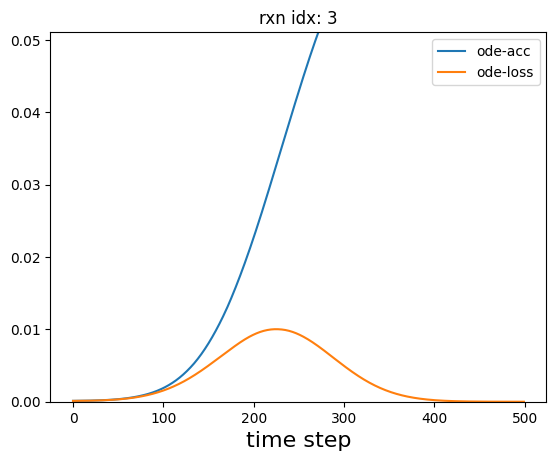

err_at_zero_t =  [0.00011870977504672697]
Done!


In [9]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

num_time_steps = [100, 250, 500, 1000][2]
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][0]
sampling_test = [0, 1][0]
print(f"q_type = {q_type}")

for idx in [3, ]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")
    
    plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

q_type = Cartesian
Debug: alpha, beta = 1.7, 0.01
Debug (0.997): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.995): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.993): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.991): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.989): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.987): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.985): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.983): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.981): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.979): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.977): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.975): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.973): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.971): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.969): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug (0.967): 
	1) diff norm and dx norm 0.0000, 0.000001
Debug 

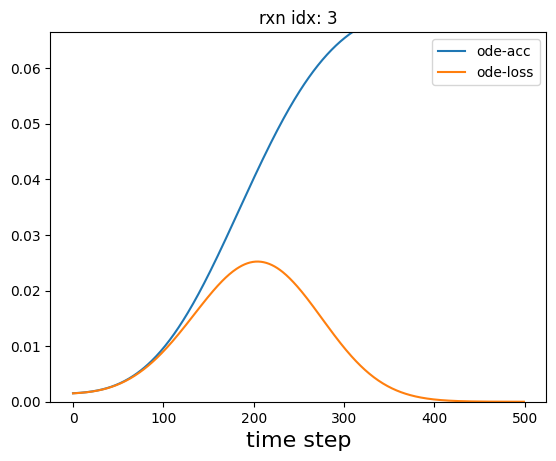

err_at_zero_t =  [0.0015210270343200493]
Done!


In [10]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

num_time_steps = [100, 250, 500, 1000][2]
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse", "Cartesian"][2]
sampling_test = [0, 1][0]
print(f"q_type = {q_type}")

for idx in [3, ]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, sampling_test=sampling_test)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")
    
    plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")